# A/B Testing For Mobile Games
---

## Outline
1. Define Business Use Case
  * Game Introduction
  * Problem Statement
  * Define the Metrics
  * Set the Hypothesis  
2. Data Preparation & Cleaning 
3. Exploratory Data Analysis
4. Chi-squared test for A/B testing 
5. Conclusion 
---

## 1.  Define Business Use Case

### Game Introduction
Cookie Cats is a hugely popular mobile puzzle [game](https://www.youtube.com/watch?v=GaP5f0jVTWE) developed by [Tactile](https://tactilegames.com/cookie-cats/) Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level.  
It also features singing cats. 

### Problem Statement
As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase.   
This sort of "time gate" is usually seen in free-to-play models, and normally contains ads that can be skipped using credits. In this case the player requires to submit a specific number of "Keys", which also can be skipped in exchange of in-game purchases.
The company is planning to move Cookie Cats "time gates" from level 30 to 40, but they don’t know by how much the user retention can be impacted by this decision.

### Define the Metrics 
In this project, I am going to analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, analyze the impact on player **retention**.


### Set the Hypothesis 
So seeing this viewpoint, a decision like this can impact not only user retention, the expected revenue as well that’s why we are going to set the initial hypothesis as:

$H_0:$ *The retention rate is the same for the two versions.*    
$H_1:$ *The retention rate is higher for the gate at level 30.*  

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.stats as stats

## 2.  Data Preparation & Cleaning 

The data we have is from 90,189 players that installed the game while the AB-test was running. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.  

The variables are:  
- userid - a unique number that identifies each player.  
- version - whether the player was put in the control group
  - gate_30 - a gate at level 30 
  - gate_40 - a gate at level 40 (the group with the moved gate)
- sum_gamerounds - the number of game rounds played by the player during the first 14 days after install
- retention_1 - the player come back and play 1 day after installing (T/F)
- retention_7 - the player come back and play 7 days after installing (T/F)
 
Dataset from [Kaggle](https://www.kaggle.com/datasets/arpitdw/cokie-cats)

In [2]:
df=pd.read_csv("cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.shape

(90189, 5)

In [4]:
df.isnull().count()

userid            90189
version           90189
sum_gamerounds    90189
retention_1       90189
retention_7       90189
dtype: int64

## 3. Exploratory Data Analysis

In [5]:
# check if there are roughly the same number of players in each A and B group.
df.groupby(by="version")["userid"].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

In [6]:
df["sum_gamerounds"].value_counts()

1       5538
2       4606
0       3994
3       3958
4       3629
        ... 
858        1
1102       1
618        1
1027       1
708        1
Name: sum_gamerounds, Length: 942, dtype: int64

Text(0, 0.5, 'User ID')

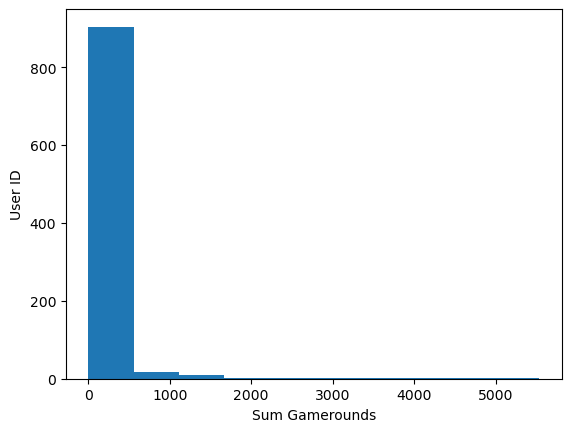

In [7]:
df_plot_data=df.groupby("sum_gamerounds")["userid"].count()
df_plot=df_plot_data.plot(x="sum_gamerounds",y="user_id",kind="hist")
df_plot.set_xlabel("Sum Gamerounds")
df_plot.set_ylabel("User ID")

Text(0, 0.5, 'User ID')

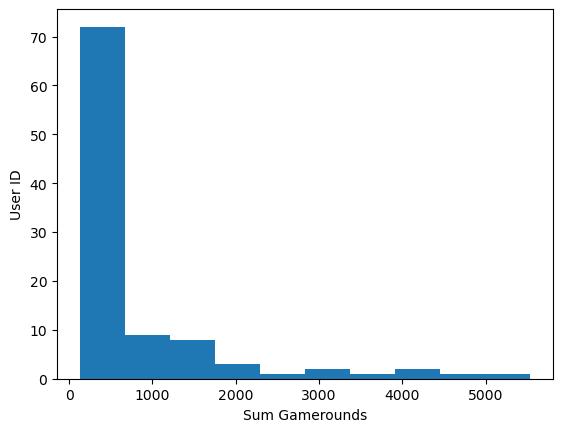

In [8]:
df_plot_data=df.groupby("sum_gamerounds")["userid"].count()
df_plot=df_plot_data.head(100).plot(x="sum_gamerounds",y="user_id",kind="hist")
df_plot.set_xlabel("Sum Gamerounds")
df_plot.set_ylabel("User ID")

In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!


In [9]:
#1-day retention
df["retention_1"].mean()

0.4452095044850259

In [10]:
#1-day retention by A/B group 
df.groupby("version")["retention_1"].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [11]:
#7-day retention
df["retention_7"].mean()

0.1860648194347426

In [12]:
#7-day retention by A/B group
df.groupby("version")["retention_7"].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 4. Chi-squared test for A/B testing
$H_0:$ *The retention rate is the same for the two versions.*    
$H_1:$ *The retention rate is higher for the gate at level 30.*  


In [13]:
#contibgency table
contingency=pd.DataFrame(data={"version":["gate_30","gate_40"]})
contingency

,version
0,gate_30
1,gate_40


In [14]:
contingency["retained_1"]=df[df.retention_1==True].groupby(by="version").count()["retention_1"].values
contingency

,version,retained_1
0,gate_30,20034
1,gate_40,20119


In [15]:
contingency["non_retained_1"]=df[df.retention_1==False].groupby(by="version").count()["retention_1"].values

In [16]:
contingency["retained_7"]=df[df.retention_7==True].groupby(by="version").count()["retention_7"].values

In [17]:
contingency["non_retained_7"]=df[df.retention_7==False].groupby(by="version").count()["retention_7"].values

In [18]:
contingency

,version,retained_1,non_retained_1,retained_7,non_retained_7
0,gate_30,20034,24666,8502,36198
1,gate_40,20119,25370,8279,37210


In [19]:
#Chi-squared test for 1-day retention
chi,p_value,_,_=stats.chi2_contingency(contingency[["retained_1","non_retained_1"]])
print("Statistic:{}\nP-Value:{}".format(chi,p_value))

Statistic:3.1591007878782262
P-Value:0.07550476210309086


According to chi-squared test, there is no significant difference in retention rates between the two versions at the 5% significance level.   
We do not have enough evidence to reject null hypothesis that retention rate is the same for the two versions.

In [20]:
#Chi-squared test for 7-day retention
chi,p_value,_,_=stats.chi2_contingency(contingency[["retained_7","non_retained_7"]])
print("Statistic:{}\nP-Value:{}".format(chi,p_value))

Statistic:9.959086799559165
P-Value:0.0016005742679058301


According to chi-squared test, there is a significant difference in retention rates at the 1% significance level.  
We reject null hypothesis and accept our alternative hypothesis that 7-day retention rate is higher when the gate is at level 30.

## 5. Conclusion 

### 1-day retention
According to chi-squared test, there is no significant difference in retention rates between the two versions at the 5% significance level.
We do not have enough evidence to reject null hypothesis that retention rate is the same for the two versions.
### 7-day retention
According to chi-squared test, there is a significant difference in retention rates at the 1% significance level.
We reject null hypothesis and accept our alternative hypothesis that 7-day retention rate is higher when the gate is at level 30.


---
### Referance
https://tactilegames.com/cookie-cats/  
https://app.datacamp.com/learn/projects/184  
https://bit.ly/2oQH6ys   
https://www.kaggle.com/datasets/arpitdw/cokie-cats  
https://www.youtube.com/watch?v=GaP5f0jVTWE
https://reurl.cc/Wq7dRZ
https://reurl.cc/858Gv4
https://reurl.cc/oZALRv
https://www.hansshih.com/post/85896239420